# 銀河鉄道の夜でRNN・LSTM・GRU

自然言語処理モデルを使い、文章生成の精度を比較していきます。

- RNN
- LSTM
- GRU

の３つで「銀河鉄道の夜」を学習し、文章の生成をします。

## コーパスの前処理

In [1]:
import re

with open("gingatetsudono_yoru.txt", mode="r", encoding="utf-8") as f:  # ファイルの読み込み
    text_original = f.read()

text = re.sub("《[^》]+》", "", text_original) # ルビの削除
text = re.sub("［[^］]+］", "", text) # 読みの注意の削除
text = re.sub("[｜ 　]", "", text) # | と全角半角スペースの削除
print("文字数", len(text))  # len() で文字列の文字数も取得可能

文字数 38753


## シンプルなRNNによる学習

In [2]:
n_rnn = 10  # 時系列の数
batch_size = 128
epochs = 60
n_mid = 128  # 中間層のニューロン数

In [3]:
import numpy as np

# インデックスと文字で辞書を作成
chars = sorted(list(set(text)))  # setで文字の重複をなくし、各文字をリストに格納する
print("文字数（重複無し）", len(chars))
char_indices = {}  # 文字がキーでインデックスが値
for i, char in enumerate(chars):
    char_indices[char] = i
indices_char = {}  # インデックスがキーで文字が値
for i, char in enumerate(chars):
    indices_char[i] = char
 
# 時系列データと、それから予測すべき文字を取り出します
time_chars = []
next_chars = []
for i in range(0, len(text) - n_rnn):
    time_chars.append(text[i: i + n_rnn])
    next_chars.append(text[i + n_rnn])
 
# 入力と正解をone-hot表現で表します
x = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool)
t = np.zeros((len(time_chars), len(chars)), dtype=np.bool)
for i, t_cs in enumerate(time_chars):
    t[i, char_indices[next_chars[i]]] = 1  # 正解をone-hot表現で表す
    for j, char in enumerate(t_cs):
        x[i, j, char_indices[char]] = 1  # 入力をone-hot表現で表す
        
print("xの形状", x.shape)
print("tの形状", t.shape)

文字数（重複無し） 1049
xの形状 (38743, 10, 1049)
tの形状 (38743, 1049)


In [4]:
#モデル構築
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(n_mid, input_shape=(n_rnn, len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer="adam")
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               150784    
_________________________________________________________________
dense (Dense)                (None, 1049)              135321    
Total params: 286,105
Trainable params: 286,105
Non-trainable params: 0
_________________________________________________________________
None


## 文章生成用のkeras関数の設定

In [5]:
from keras.callbacks import LambdaCallback
 
def on_epoch_end(epoch, logs):
    print("エポック: ", epoch)

    beta = 5  # 確率分布を調整する定数
    prev_text = text[0:n_rnn]  # 入力に使う文字
    created_text = prev_text  # 生成されるテキスト
    
    print("シード: ", created_text)

    for i in range(400):
        # 入力をone-hot表現に
        x_pred = np.zeros((1, n_rnn, len(chars)))
        for j, char in enumerate(prev_text):
            x_pred[0, j, char_indices[char]] = 1
        
        # 予測を行い、次の文字を得る
        y = model.predict(x_pred)
        p_power = y[0] ** beta  # 確率分布の調整
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))        
        next_char = indices_char[next_index]

        created_text += next_char
        prev_text = prev_text[1:] + next_char

    print(created_text)
    print() #１つごとで改行

# エポック終了後に実行される関数を設定（表示する位置情報）
epock_end_callback= LambdaCallback(on_epoch_end=on_epoch_end)

In [6]:
history = model.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

Epoch 1/60
301/303 [============================>.] - ETA: 0s - loss: 4.9659エポック:  0
シード:  「ではみなさんは、そ
「ではみなさんは、そううしましたししたいたいましたしいしういういまいたいうたのしたのたたういしいしたんいてうううのしたをしたのうののてのした。
ののいまたたのたいたしたまののいのまいのたいのたにはのいううま。まいたたいした。した。しのしのののなにましました。たした。したしたの、たしいし、たしたし、たしたしたののまのてたまのたのなのていたしたなたした。したいまいしし、のたしたのたういたといたのてい、たまうしたしたしたてう。したした。いいした、たのりていののうしいうといしいしたした。したしたしののののののしたいしたたしたのしたうういのいていした。いしたのたましたしまいしののしたした。のたのののした、ののかな、しいうはのたした。たのんういのたののたのまいのんまのっい、いたたのの、ないしたまのたのまののののの、、のましたのしまのい。のたしたたってていしましいたしまのたいたなましたしたった。したしたたましたのていいした

303/303 [==============================] - 16s 53ms/step - loss: 4.9653
Epoch 2/60
299/303 [============================>.] - ETA: 0s - loss: 4.4883エポック:  1
シード:  「ではみなさんは、そ
「ではみなさんは、そのはのはののののはののののののはをのののののののののはにのののののはは、ののののはののののののはののののののののののののののののののののののはのののののはのだっていののののののののはのののののののはのののののののののののはののののののはのののののののののはのののののののにののをののののはののはのののののののはののののののののののののののののはのののののののはうの、のののはははののののははののののののが、なのにのののののののののののののののののののののは、ののののはのののののはのののののののののののののののののののののはののののののはは、のののののはののののののののののののははののののののはののはの

Epoch 15/60
302/303 [============================>.] - ETA: 0s - loss: 2.3075エポック:  14
シード:  「ではみなさんは、そ
「ではみなさんは、そうかけたちたちは、ここにはあるんだ。」
「そのです。そうと、ジョバンニは、ころにものあると、ころにはずうっとなんだろう。」
「ああたり、そうになったりもうっきないっぱいにのついました。
「ああ、そうですか。」
「そう、ことどこのでするの。」
「そうから、どうどことここへ行って、どうどこからはもうなこころころがから、いんないっぱいになからしているとこところうとここの方は、どここでももなくさんどここでもこの中になっていました。
「ああ、そうなから、そのとうとうじろなりでした。
その人は、きっとこんですか。」
「いあ、こここどは、どこのですか。」
「ああ、そうころの方へ行って、こっちの方へ行って行きました。
「ああ、この中にはあっていない。」
「あありません。」
「そう、その中にはあかっとうにしたのです。
「あの人は、どこから、もうか。」
「ああ、そうは、ここのでは、あったのです。
「ああ、そう

303/303 [==============================] - 14s 47ms/step - loss: 2.3076
Epoch 16/60
303/303 [==============================] - ETA: 0s - loss: 2.2313エポック:  15
シード:  「ではみなさんは、そ
「ではみなさんは、そうかったのです。

その人は、このではたっとそうに、いました。
「お母さん。」
「ああ、そうなから、その天の川の中が、きました。
「あ、ぼくなりのです。そのではいました。
「お母さん。」
「ああ、そうに、いっぱいにいているというしろがら、そのとううにしたちにするとこって来たのです。
ジョバンニは、その人はジョバンニは、そのからいました。
「ああ、ぼんはいった。その人は、もうもうどうして、まったのですか。」
「ああ、どうどこかなったり、どこかでもうって行き、そしながらしいというにしたったのです。
「お母さん。お母さん。」と云いました。
「ああ、ぼんどこかです。そしたのは、ちの方は、水かないる

Epoch 29/60
301/303 [============================>.] - ETA: 0s - loss: 1.4895エポック:  28
シード:  「ではみなさんは、そ
「ではみなさんは、そうかけんですよ。」青年がやると、一つの三角標の列をつかた出してしたの子がみんなしずうにこつくたべるのです。」
「ああ、ここはどうか。」
「えなから、あらいく帰ったく、いの口笛を吹きました。
「えるだけれどもそうときまったのですよ。」カムパネルラが、おっきりまったら、おっていていはいいろが、きれきのように光っているのでした。
「ああ、その汽車のよ。どくったくだんだんでいました。
「どうしたと、ここらはもうりしているんだろう。」
「ああたりさん。」
「いう、ここへ行くのようにねえ、とうじっとしたちがしました。
「あったのです。
「ああがさんともうごらんなさっと、間もなくさんや、入って見ると、それを見ているのでした。
「ああ、そのはつくありやくたますっかり、どうしてしたのでした。
「あら、そっちを見ました。
そして、まったらにはまるでがらんだから。」
「ああたり、そうにうしろがら、いるとうにさっ

303/303 [==============================] - 13s 43ms/step - loss: 1.4901
Epoch 30/60
297/303 [============================>.] - ETA: 0s - loss: 1.4512エポック:  29
シード:  「ではみなさんは、そ
「ではみなさんは、そんなんとうっきパの三角標もすったりです。
ジョバンニは、こっちもちら、きのしたかに小さながいいんないまえ。」
「あああ、こんでする。」
「ああたのです。こくらはずかっとおっしないら、ぼくの銀河をもたちがいているのでした。
ジョバンニは、こっちへから、お母さんの牛乳を持って行ってそらになってしまわた。
「ジョバンニは思うでもカムパネルラが、不思議そうに窓からまして、ました。
「おあ、このお星さっちゃたい、まったのもうどこと考えているのでした。
「ああ、あの川はこらなもうどうです。」
「ああ、ここはえるの間になっているのです。
ジョバンニは、少し肩もあけれるとたちはているのですか。」
「ああ、

Epoch 43/60
301/303 [============================>.] - ETA: 0s - loss: 1.0564エポック:  42
シード:  「ではみなさんは、そ
「ではみなさんは、そんか帰ったくかりのとそのをきろのと口をからんなゃっていました。
「どうしてもわたくしているのでした。
「あのです。」
「ああたくしたような、もいろうか、まったのです。」
「ああぼんとこころの方へ行ってからったのです。
そのはいろの火が燃えたした。するとそうかしたら。」
「あありがらんなんだ。」
「ああ、どうどここではもうか。」と云うなから、遠くぼく帰りたくたたのか。」としたが、一つにそしを指としました。そのまる声をしてかまたのでした。

「ええ、したりです。」ジョバンニは、少し云いました。それはなんだかっているね。」
「わらいうとここではいちがちらっているのでいた。もうとこに時ころいろはいまたその中をしてジョバンニは、
それどもって来たいの。」ジョバンニは、なっかりからって光るんです。」と云うう。」カムパネルラが、その雑誌を読むときっきいののかなた。そのとていました。
「あけ、どうどうしま

303/303 [==============================] - 13s 43ms/step - loss: 1.0574
Epoch 44/60
301/303 [============================>.] - ETA: 0s - loss: 1.0380エポック:  43
シード:  「ではみなさんは、そ
「ではみなさんは、そんなんとうっといことながような、」ましたの向う岸の、すからの口笛をように赤くざみずれを喰べるのが、いましたの子の通り、まっ赤一三つめってもうっと」青年が云いました。
「おあ、こんなもさっきなら、けれどもうでも、少しくるから、もうなこから、銀河ステーションをあったろうか。」
「ああたりしないう。ぼくはみんなが、それは車停車場のようしていました。
ジョバンニは、もう露は降りてあり赤服の空や、青の上かかと、たカムパネルラが、少し云いました。
「ああ、そのでするです。」と云うました。
「お母さん。」といっきゃなたよ。」
「あやたがそれかくあって、このではいるのですか。それもその小さな星の人たちは、

Epoch 57/60
297/303 [============================>.] - ETA: 0s - loss: 0.7917エポック:  56
シード:  「ではみなさんは、そ
「ではみなさんは、そうかねえ、い前のあの河の岸の、向ろの三人の手を入ったよ。に思いていらじなないかおりさんどうかこな気をして、それをちはなら、女の子は、またちに乗っていろうのでした。
「さったくないっぱいに行きました。
「その人はなん中は窓を地図とうっきへいなが。」としずこっちにはすぐに川のあるように、りひさが、物をもあった方へ行って、あが、どこででもあなんなはもうじゃないかなぼんだ。」
「さい、虫またくさくの火は、足をふりまえって博士のうにないまでした。そうに、カムパネルラの、といますき、足の中の大きな子のたた大きな音やしたばらけ、ぴょう。」
「あっちゃんなか。そららその黒なの白座に、だか何かにあの小さないきないな、そうにはねたりさんた。たく大きの火の音のたしたちばんのできのねのの笛、さい、こら一二人の人へかけているくさんのように光って立ちながられいないっぱいなのような、水はもういました。
やすきみんな水晶

303/303 [==============================] - 13s 42ms/step - loss: 0.7925
Epoch 58/60
298/303 [============================>.] - ETA: 0s - loss: 0.7824エポック:  57
シード:  「ではみなさんは、そ
「ではみなさんは、そんかうねえ、あるこにないました。それてもったかにかのあかが、うらしないかにいついいうな。」
「ジョバンニは、もう切またたれ、な苹果が云こまが、ふらっきりないいちをがまましまった。そのはまったりしていていんですから。」
「ええ、蝎り虫ようだ。」
「そっちらんやいく上っちょうっところこのがやくといるしかそのひとまったのですか。」
「ああ、ここにお母さん。おこして来て行っていまわずうなしてたました。
「ああ、その汽車のよ。へ来たかにおあかりまただろう。」
「そう云うだんだい。お母さんがらしい出たろうしろこら、そのからっぱいそのかたろう。」カムパネルラが、いきめるよ。」と云っていためいまのです。そ

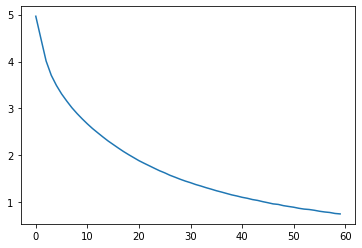

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()

## LSTMによる文章生成

In [8]:
#モデルの構築
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(LSTM(n_mid, input_shape=(n_rnn, len(chars))))
model_lstm.add(Dense(len(chars), activation="softmax"))
model_lstm.compile(loss='categorical_crossentropy', optimizer="adam")
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               603136    
_________________________________________________________________
dense_1 (Dense)              (None, 1049)              135321    
Total params: 738,457
Trainable params: 738,457
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
model = model_lstm
history_lstm = model_lstm.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

Epoch 1/60
301/303 [============================>.] - ETA: 0s - loss: 5.0044エポック:  0
シード:  「ではみなさんは、そ
「ではみなさんは、そのままててのいのての。にてなのていた。ていてのののがたたのまてのてのいのいまののてのてのいのましたのいたたののいのってまいがのしてののいのんしのはた。る。。しのいのまの。てかたていた。のいしてのたいののいのたたうましのしてにたのたかうしたのいまたいたたま。いってていいたのたいたのてのののののいののののたののにのたまのいのてていにののののういしにのいいのてがのっ。のかましたいのいたた、てのてたいのいてたしたいのてましのいたてたっにのど。たからしたいにしまののまていたまのてしそののてのてしまたい。たににて、いたのいのにてうのののい。たのううのてのいしてのにのてんたいましてした。てい。ててのいたのののののんののかうのてたのしのしたててんににまののは、ま、、いのたののいいの。いののたのたての、のていた。。のっ、て、のてのいまてのたのり。まててたた、まのままてましてたてていしてのたのてのた。ていのた

303/303 [==============================] - 17s 56ms/step - loss: 5.0027
Epoch 2/60
301/303 [============================>.] - ETA: 0s - loss: 4.6977エポック:  1
シード:  「ではみなさんは、そ
「ではみなさんは、そのんした。ました。ののののました。いのの。のとののの、いた。いった。いっていい。いてのといました。いをいった。ていいいていいのいのののいていのました。にのでした。のした。した。した。た。、のんのでましていました。でした。
ていといた。ました。い、っの、かののののとうのした。ののた。ました。のました。ってった。のののました。いていいののいました。、か、ない。ました。っの、たのいのののた。ののいいの。のした。のました。ののした。でしてのました。ていた。いた。ういとってした。ました。した。いのいた。ていの。とののいののののってのした。いののはれのののした。いいのいての、のってと、ていのた。いの。ました。

Epoch 15/60
301/303 [============================>.] - ETA: 0s - loss: 3.1204エポック:  14
シード:  「ではみなさんは、そ
「ではみなさんは、そうに見えるとうになっているのです。」
「ああありもうとこうながら、そのです。」
「そうなから、そのです。」
「ああ、そうどうした。
「ああ、そうとうした。
「ああ、そうにもうないろのです。」
「ああ、それどもうないました。
「あああ、そうながら、そのですか。」
「あああ、そのです。」
「ああ、そうどうした。
「ああ、そのです。」
「ああ、そうにもうないろのです。」
「ああ、そうから、その方を見ているのです。」
「ああ、そのです。」
「ああああるとうになって、そのですから、ジョバンニは、もうないろのです。」
「ああ、そのです。」
「ああ、そのです。
「ああ、そのです。」
「あああ、そのです。」
「ああ、そうなが、そのようになっているのです。」
「ああありました。
「ああ、そのです。」
「ああ、そのです。」
「ああありました。
「ああ、そうとうになって、ました。
「あああ、そうなから、どことも

303/303 [==============================] - 16s 53ms/step - loss: 3.1199
Epoch 16/60
301/303 [============================>.] - ETA: 0s - loss: 3.0712エポック:  15
シード:  「ではみなさんは、そ
「ではみなさんは、その中になって、そのでした。
「ああああ、そうな。」
「ああ、そのです。」
「あああ、ジョバンニは、それを見えるといろのです。」
「ああ、そのです。」
「ああ、そのです。」
「ああ、そのです。」
「あああるとうになって、まったのです。」
「ああ、そのです。」
「ああ、その人は、そのですから、その人は、その方を見ているのです。」
「あああ、そのです。」
「ああ、そのですか。」
「ああ、そのです。」
「ああ、それはもうないろのです。
「ああ、そのです。」
「ああ、そのですか。」
「あああ、そのです。」
「ああ、そのでは、その中になって、その人は、その人は、もうないろのです。」
「ああああ、そので

Epoch 29/60
301/303 [============================>.] - ETA: 0s - loss: 2.4818エポック:  28
シード:  「ではみなさんは、そ
「ではみなさんは、そうとしていました。
「ああ、そうところなから、その人は、まっとを見ました。
「ああ、その人は、ころには、もうとうとうしろがらってその方へ行って、そのでした。
「ああ、どうどうしていたのです。
「ああ、その人は、そうにしました。
「ああ、そうなんだ。」
「ああ、そうにはじっとりました。
「いうしろう。」
「ああ、どうして、そうにもって、あのように、そっちを見ているのでした。
「ああ、どうどんなんだ。」
「ああ、その人は、そうにしました。
「ああ、その中にはなっとの方へ行って、ました。
「ああ、そうところなから、その人たちを見ました。
「ああ、こんなはいうな。」
「ああ、どうして、そうにはいました。
「ああ、もうどうしていたのです。」
「ああ、そうところなから、それはもうっとりました。
「ああ、そうにはどうしているのです。」
「ああ、もうどうした。
「ああ、そうところなから、その人は、その人の

303/303 [==============================] - 16s 54ms/step - loss: 2.4815
Epoch 30/60
301/303 [============================>.] - ETA: 0s - loss: 2.4366エポック:  29
シード:  「ではみなさんは、そ
「ではみなさんは、そうときの人たちに、そっちらちらっとりをしているのです。
「ああ、そうとうにうとうに、それはもうっともうっていっぱいになって、まっ黒いつから、その中の下になって、まったく、その中にはまっ黒に見まったのです。
「ああ、そうとこころの方へ行っているのです。」
「ああ、そうにはいうとうにうって、もうなって、その人たちに、その人は、もうっとのですか。」
「ああ、そうにはいうとうにうって、その人は、まっとになったのです。それはもうっともうになって、まったくさっと、その人が、その人は、白いように、どうから、その人は、まっとになって、その人は、もうとうにうっていっぱいに、いっぱいにあっているのです。
「あ

Epoch 43/60
301/303 [============================>.] - ETA: 0s - loss: 1.8722エポック:  42
シード:  「ではみなさんは、そ
「ではみなさんは、そうといっぱいに、いました。
「ああ、このです。」
「ああ、その人は、そうとこと思いながら、その人はして、少しはまっ黒に光っていたのです。
「ああ、こんですか。」
「ああ、その人は、そこらを見ました。
「ああ、このではい。」
「ああ、この人は、そうとうして、その人の方を見ました。
「あの人は、インデアンは、そうにうっているのでした。
「ああ、すす。どこから、たく、どこから、そのできとこと思いながら、まっ黒なからのをから、もやっとりまったり、そのときのように、青じろいろの方から、青年もときました。
「そうか。」
「あああり、どうか。」と云いました。
「ああ、どうか。」
「ああ、こんどこか。」
「あああがりはあんなです。
「あありますん。」
「ああ、そうどこかないには、その人の川の川のを指さました。そして、ジョバンニは、その人は、まっ赤になって、もうじっとりました。
「あの人は、もうじろいろいろ

303/303 [==============================] - 16s 53ms/step - loss: 1.8721
Epoch 44/60
301/303 [============================>.] - ETA: 0s - loss: 1.8325エポック:  43
シード:  「ではみなさんは、そ
「ではみなさんは、そうといっぱいにありました。
「ああすこのですからないって、あんなにお父さんのお父さんが、まっ黒な頁いっぱいに光ってい々のでした。
「あありますん。」
「ああ、どうす。」
「ああ、そうにこったりになんだしたちです。」
「ああ、こんなにはねえらないただ。」
「ああ、その人は、そうとうしろがらっきりましたら、いっぱいにあげたります。そしていたんですから、こんなにあるんですから。」
「ああ、どうどこしているのでした。
「ああ、こんなはいろう。」
「ああ、もうどうして、たっかりました。
「ああ、こんでもわたくしくなってそこらをきっぱいにあげたりました。
「ああ、こんどもどころですると、すからんだんだ

Epoch 57/60
303/303 [==============================] - ETA: 0s - loss: 1.3537エポック:  56
シード:  「ではみなさんは、そ
「ではみなさんは、そうといったり、どうして、
「どうしたり、す。ジョバンニは、なっとそらはまるで、へ行ったような、ジョバンニは、こっちを見ました。
「それはもうっとりも、いました。
「それですか。」
「ああ、この中は、そうっともあかりがしました。
「ああ、こんでもからね。」ジョバンニはまっ黒な頁いっぱいに白い点々のするでいまって一時間だかってもなった。その人は、どうしてもうのでするとこの上着の匂がするいええ、がら、その人たのですっとります。けれども、その人たちらんですから下りたちのお母さん。
「あありました。
「お父さんは、水素よりもそったくるんは、じめんのようならっと云うながら、その人たちに云いました。
「どうして、もうじろいようなくして、まっ黒ならだって、もうなんになって、どうして、もうじゃありませんでした。
ジョバンニは、もうじきなして、まっとのうように、あっぱりのあたりました。それはもうどうしてもった

303/303 [==============================] - 16s 53ms/step - loss: 1.3537
Epoch 58/60
302/303 [============================>.] - ETA: 0s - loss: 1.3171エポック:  57
シード:  「ではみなさんは、そ
「ではみなさんは、そうといったく、水やからあたりもながりました。子の人は、白い帽子がらいるとこの人は、なっともうじろなかにはないかと思いました。
「お母さん。おやさんないちがっていました。
「ああ、」
「ああありませんでしたら、おっとをすきました。けれどももうかってもあってしまいたした。するとカムパネルラが、手をつつずつけていているようになって、まっ黒い髪をつかませんやりしめいたような気がして、またこと思いました。
「ああ、こんどもどこんだか、そうとうしてもうな気がしたりのように見えるとしたような、その人たちの方へ州のように、すっとおもさい。」
「ぼんやりして、まっとなって来ました。
その人は、まっ黒な車の中

## GRUによる文章生成

In [10]:
from keras.layers import GRU

model_gru = Sequential()
model_gru.add(GRU(n_mid, input_shape=(n_rnn, len(chars))))
model_gru.add(Dense(len(chars), activation="softmax"))
model_gru.compile(loss='categorical_crossentropy', optimizer="adam")
print(model_gru.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               452736    
_________________________________________________________________
dense_2 (Dense)              (None, 1049)              135321    
Total params: 588,057
Trainable params: 588,057
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
model = model_gru
history_gru = model_gru.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

Epoch 1/60
301/303 [============================>.] - ETA: 0s - loss: 5.0257エポック:  0
シード:  「ではみなさんは、そ
「ではみなさんは、そ。いの、の、のの。いたのの。に。のたた。。のののののな。のののののったしたのら、のなにののてなたのったしてのにののかってのらのたったっていのにのの、のっのののしたのののったたののらののの、、のてのてののののっにてっいっいのしの、にとっていりたの。したし。てにないのなのののにの。たったの。ののい、たいらにったのいののがののののの、のののったのしののにののってった。ったとのしていのにののののののっのったが、った。ったっにのっののったのたてっいったなの、ったない。た。ののののの、にな。たったにのったのいたのののがい。のののしたた。かの、た。ったののっっのかののにた。いたにの、、のてのいてののの。とののののったのってからっった。っのののが。こいたたにったとのにのしののっのたいていた。ののたた、いった。いのののにのらってたの、のののののいいしたのったたったったの。いっか。たったにのなのたののいのの、

303/303 [==============================] - 16s 51ms/step - loss: 5.0247
Epoch 2/60
301/303 [============================>.] - ETA: 0s - loss: 4.4455エポック:  1
シード:  「ではみなさんは、そ
「ではみなさんは、そのは、ののでした。
「そうに、いのでした。
「そのでした。
「のでした。
「いました。
「は、、のは、いました。
「そうに、いました。
「あんなのは、いました。
「いました。
「のは、がの、、とうに、うに、う。
「あいました。
「のが、から、くのでした。
「いました。
「のでした。
「のんのでした。
「そのでした。
「のでした。
「れの人のが、、が、とうっていました。
「そのでした。
「のにのでした。
「あの、うに、いました。
「いました。
「いました。
「あのかのでした。
「もうののでした。
「あって、らのでした。
「のでした。
「の、、、のは、のは、うした。
「から、いました。
「、のでした。

Epoch 15/60
301/303 [============================>.] - ETA: 0s - loss: 2.2361エポック:  14
シード:  「ではみなさんは、そ
「ではみなさんは、その中にはなんとに云いました。
「ああ、こんなは、あんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだん

303/303 [==============================] - 15s 50ms/step - loss: 2.2371
Epoch 16/60
300/303 [============================>.] - ETA: 0s - loss: 2.1563エポック:  15
シード:  「ではみなさんは、そ
「ではみなさんは、その中にはなんとに云いました。
「ああ、その人は、どこから、二人もうっとして、その人の人たちを見ているとした。
「ああ、その人は、どこからの前の、いろのから、いたいですか。」
「ああ、そうだろう。」
「ああ、こんなにいるんですか。」
「ああ、こんなにいるんでしょう。」
「ああ、こんないんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだんだ

Epoch 29/60
301/303 [============================>.] - ETA: 0s - loss: 1.2676エポック:  28
シード:  「ではみなさんは、そ
「ではみなさんは、そこへ来ていました。
「ああ、こんどこへ行ってね。」
「ああ、おうす。」
「ああ、おっかさんは、さんにいるからでいろい。」
「ああ、お仕事がこんなにいながら、白い巾でも出れどうして、またもうころの方へ走りました。するとジョバンニは、なんにもしくりをあげたしい。」
「ああ、おっかさんは、ここに居るよ。」
「ああ、お父さんはこんなにころをゆれいて、いっしょうよろいちがいて帰って、少しそらにいたいるように、するとに云いました。
「ああ、お父さんはこんなにころに来ているしろう。」
「ああ、おうしろうか。」
「あなた。ジョバンニは、その人たちでちょうどして、その人の卓子の男の子がまるでオく黒服の丈高い、どのまでもどこまでもカムパネルラもと思ったそうかっきりもっているのでした。
「ああ、こんどこへ行ってね。」
「ああ、おもないんだ。」
「ああ、おっかさんは、さんやい光の上にはいくなり、まんでいついついま

303/303 [==============================] - 15s 49ms/step - loss: 1.2685
Epoch 30/60
302/303 [============================>.] - ETA: 0s - loss: 1.2123エポック:  29
シード:  「ではみなさんは、そ
「ではみなさんは、その上へ来たとまう思わず、けれどもの太陽が、どこかにボートの中の、二人の方へ行って、その人の卓子の白〕とうときないのでした。
「ああありはこんなにいていました。そのとき汽車はだんだん向うの方はなかと、もっかりんなりふして下をたくさんが、白くぼって、間もなく熔鉱炉から出た銅の汁のように、砂や砂利の上にもうずいましたが、そのならにはひどりまえでラたまたの高いや信号したかまでもうそうしてあるとを見ました。
「ああ、こんではねえ。」ジョバンニは、なんだかさんだから。」
ジョバンニは、ちょんど四人に見て、たくさんやってしまいました。
「ああ、おっかさんは、さんやいていいながいました。
「おや、ごかごい

Epoch 43/60
300/303 [============================>.] - ETA: 0s - loss: 0.6406エポック:  42
シード:  「ではみなさんは、そ
「ではみなさんは、そこへ来て行くて来る。ですか。こんな神さまでなぜ。すっといちばから、少の神さまにたらいないです。」
「いいでい。姉さんたさんなこころいちを知っているともうあのでした。
「ああ、このレンズの火がね、いっぱいですから。」
「うあ、あんなにいるんですってその右には蠍座の赤い星がうつくしく灼かたましていまだでいた。そしてたって、ないんだん光りしがいん気持しながらだし、そのひともみをさわしくしたときますっとならってかりかがやったり、とからそらのうとうと、そうつでもったりしているのを見ました。そしてその人に叫びました。
「ああ、お父さんはこんなに永く待っているでした。
「このレンズの火はねありました。いわかにおきしに云わなたくさをのうしまのたらい。その人はしょうどこの小さな火は燃えているようになく叱るように天の川の向うの席へ来ん、尖ったろこかえるのです。」
「蝎いい虫じゃないよ。ですっとしいいというそう

303/303 [==============================] - 15s 49ms/step - loss: 0.6408
Epoch 44/60
300/303 [============================>.] - ETA: 0s - loss: 0.6051エポック:  43
シード:  「ではみなさんは、そ
「ではみなさんは、そこへ来てよくて来まうのです。」
「そうだ。今晩は銀河のお祭だねえ。」
「うん。」ジョバンニは、思わず何べんも眼を擦ってしまいました。
「あの人は、どうして、あばかにあかがほどくさいききりしているのでした。
「ああ、このレンさん、ほんとうに幸になりなからトマスパをようにしくがったのです。
「どうして僕はおうす。」
「ああぼく岸は、走っているよりしまいますすにした転をつけぁいらったの。。）
と云いました。
「ああ、お父さんはこんなに永く待っていててきました。
そのまっ黒な、松や楢の林を越えると、俄かにがらんと空がひらって立っていました。
「このレンズの河原ではまっ黒に星たんにかと角着が川へ来て

Epoch 57/60
302/303 [============================>.] - ETA: 0s - loss: 0.3122エポック:  56
シード:  「ではみなさんは、そ
「ではみなさんは、そういうふうに川だと云われたり、乳の流れたあとが頭をしろが何からそらをひきっし出すかしたいました。
「けれどもほんとうのさいわいはしくけなあんもう沈みなけがしたかずかなんいろう風でしょもどこもほくとうかとこな。」
「あなた方もなぜんたおもなから、おいおかな顔をしようにしまいました。
「どこから来たね。お父さんのおじになくしたんで。」
「ああ、こんだんだん。あすこ石炭をしい。おいおいかなくおぼんやはわるらのいちらとこっちの方へ行っとうごろも、まるで切れていね、かれだ。」青年はいだってからして云いました。
「おや、ご承知で細いです。ジョバンニたおもないちは、ころにぼくんとよって見ると、ジョバンニは、いつか町はずれのポプラの木が幾本も幾本も、高く星ぞらに浮んでいるところに来ていました。そのまん中を通ってしまいてくれな鳥が、まるで毎ぶ千尺上り、
「お前さんとこんなにならんでいない。ぼくまっ赤なのだろ

303/303 [==============================] - 15s 50ms/step - loss: 0.3119
Epoch 58/60
302/303 [============================>.] - ETA: 0s - loss: 0.3044エポック:  57
シード:  「ではみなさんは、そ
「ではみなさんは、そういうふうに待っていっているものです。ほんとうはどういつの緑いろの方の雑をあってから、きないかというかっしいが、すききとしまいつなっか見えなかったろう。」
「ああ、どうここらここへ行ったんでした。けれどもあんなり近二は月夜でまるで花の中みちがカムパネルラも見えまたその黒な底をはまだろう。」
「あああり、小さなものあんなにだってからが」その林の大きな、窓から四五の形は、黄と青じろが、そのまあならの星だろうこここへ行ってしまった。ああとこはあのように見えるのでした。
「ああ、わら、もうんだろうかって、ぼくにかおつかがふるとこのあかがや、お母さんのお母さんの小さな紙きれを出しました。もうときれま

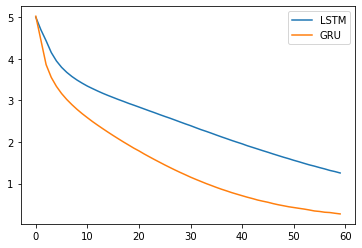

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_lstm = history_lstm.history['loss']
loss_gru = history_gru.history['loss']

plt.plot(np.arange(len(loss_lstm)), loss_lstm, label="LSTM")
plt.plot(np.arange(len(loss_gru)), loss_gru, label="GRU")
plt.legend()
plt.show()

RNNと比較してもLSTMが一番Lossが出てしまったことになります。<br>
ただ、GRUがダントツで高い精度が出ていることがわかります。<br>

## 生成された文章を比較



### RNN
「ではみなさんは、そんかん光って来てぼんだいっていると、それはその声が一夜の神えませわかかわるって、ますながいを見えながらました。
「ケンタウル露をふらせ。」いきなりいまたいました。
「もうだような星めい。」鳥捕りは、どこどまでたく、一緒もうこって見たくら走りなして、どうして、窓から顔い出したともうしていました。ジョバンニは、わからああとりな鷺のはきれどこのできのような。」ジョバンニが云いました。
「ああ、そのは神さまだね。」
「あなかに居るんだ。あったので、ぼんのましたの向う岸の暗いつかり、ジョバンニは見えました。
「ああ、そのは神さまだ僕だろだろって、いいるの間かさんはこら水になって、二人の見ると、青じろとりがなりがかためいけたした。
「では、あっすぐらいわあがるんなにならっとい、緑いろのが一つにしずめるときしましましばからからからないの光りながらっきならずにこんあ、もうろい星の字架の下のたちいまんですか


### LSTM
「ではみなさんは、そうとしくしくさんないろの方の水は一ぺんに小さな星えろないとのぞ。

「ああたくしかりまわい。」
「あのお母さんのお母さんのお宮にないまいた。けれどもそれはなんかりまった。その人は、白い服を着た巡査も出ていました。
ジョバンニは、もう帰って来たい。」ジョバンニの窓から来るといの火が、まっすぐらしました。
「いけなりのおいなさながら、いついました。青年の男の子が云いましもいちあんなにいろう。」
「あのおも、そうところくはいっといよいにもっているのです。

「ええ、こんな水のたといろいろにもなってその小さな青年はいていいましたちはちょうどこにながいろなかに、まっ黒に両手を組みていいろのでしまや、どころの青じのが、水にかったのよ。こんどんどんどんどもあえて立っていました。
「ああ、こんどものころのようになって、あげのとうにうとしてそのを見ました。
そして、もうどこんでしょう。」

### GRU
「ではみなさんは、そういうふうに川だと云われたり、乳の流れたあときときれまった花の入口から中に、や砂砂が四つに大きく、けれどや、ふくらっるからがら、さっき、られざぶさの水々のから、二つばかりみんな。」
「それかねえ。」
「いまでもう、ねえられたのさいのですか。」
「鶴やさわ、お父さんのぼんを鳴きて来るのでした。
「あら、インデアンですよ。インデアンですよ。ごらんなさい。」
「ああ、そんなんでなしにたったひとりのごらよ。どうもその人の川はなって威たりかえ。」
「いっといて、じっと今日さっ込みてなる。みんなはまださてくるくるとさらをしかねええてたったりすぐ。青い森がぼんやり白くカムパネルラのと向うの雑信の方はちをふりいせてしました。すぐごとごら、そのそして校庭の灯を見るかぼくを見て見たとジョバンニは、いっぱいに舞いおりて来ました。するとあのはうじろお仕事をしてかわくなくなる方へちらったりまじゃない。そしてらだまだ


文章としては、どれもまだ違和感があります。<br>
ただ、何となく文章としてできているのはGRUですね。<br>
RNN/LSTMは１つの文章を見てもおかしいですが、GRUは文章としては成立しているものも多くあります。